In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Statevector, random_statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator

In [2]:
# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica con estado W
def crear_estado_w(qc, a, b, c):
    # Crear un estado W en los qubits a, b y c
    qc.ry(2 * np.pi / 3, a)
    qc.cu(np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, a, b)
    qc.cx(b, c)
    qc.cx(a, b)
    qc.x(a)


def circuito_de_alice_w(qc, q2send1, q2send2, beta0, beta1):
    # Alice aplica operaciones en los qubits a enviar y los qubits de Bell
    qc.cx(q2send1, beta0)
    qc.cx(q2send2, beta1)
    qc.h(q2send1)
    qc.h(q2send2)

def medicion_de_alice_w(qc, a1, a2, b1, b2, crz1, crx1, crz2, crx2):
    # Alice mide sus qubits y almacena los resultados en bits clásicos
    qc.barrier()
    qc.measure(a1, crz1)
    qc.measure(b1, crx1)
    qc.measure(a2, crz2)
    qc.measure(b2, crx2)
    qc.barrier()
    qc.barrier()

def circuito_de_bob_w(qc, beta1, beta2, m1, m2, m3, m4):
    # Bob usa los bits clásicos para aplicar compuertas de manera condicional
    with qc.if_test((m1, 1)):
        qc.z(beta1)
    with qc.if_test((m2, 1)):
        qc.x(beta1)
    with qc.if_test((m3, 1)):
        qc.z(beta2)
    with qc.if_test((m4, 1)):
        qc.x(beta2)

In [3]:
# Definición de registros de qubits de entrada
Q2teletransport = QuantumRegister(2, name='Qubit_C')  # Ahora contiene 2 qubits
QEntanglem_A = QuantumRegister(2, name='Qubit_A')  # Ahora contiene 2 qubits
QEntanglem_B = QuantumRegister(2, name='Qubit_B')  # Ahora contiene 2 qubits

# Definición de registros de bits clásicos para medida
crz1 = ClassicalRegister(1, name='crz1')
crx1 = ClassicalRegister(1, name='crx1')
crz2 = ClassicalRegister(1, name='crz2')
crx2 = ClassicalRegister(1, name='crx2')
crbob = ClassicalRegister(4, name='crbob')  # Ahora contiene 4 bits clásicos

# Definición del circuito de teletransportación cuántica
teleport_cir = QuantumCircuit(QEntanglem_A, QEntanglem_B, Q2teletransport, crz1, crx1, crz2, crx2, crbob)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

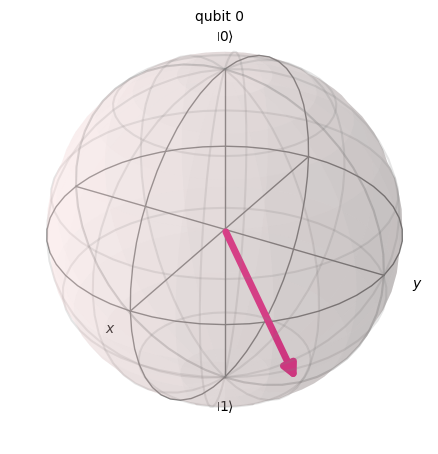

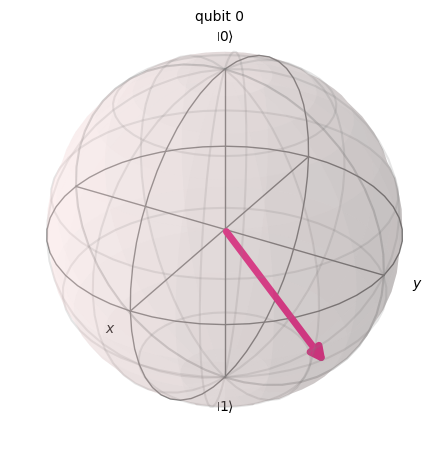

Las probabilidades del estado cuántico aleatorio 1 son: [0.06313923 0.93686077]
Las probabilidades del estado cuántico aleatorio 2 son: [0.11009425 0.88990575]


In [4]:
# Definición de dos estados cuánticos aleatorios de entrada para ser teletransportados
qrandom1 = random_statevector(2)
qrandom2 = random_statevector(2)

# Mostrar los estados en notación de Dirac
display(array_to_latex(Statevector(qrandom1), prefix="\\ket{\\psi_1} = "))
display(array_to_latex(Statevector(qrandom2), prefix="\\ket{\\psi_2} = "))

# Visualización en la esfera de Bloch
fig1 = plot_bloch_multivector(Statevector(qrandom1))
plt.show()

fig2 = plot_bloch_multivector(Statevector(qrandom2))
plt.show()

# Mostrar las probabilidades de los estados cuánticos
print("Las probabilidades del estado cuántico aleatorio 1 son:", Statevector(qrandom1).probabilities())
print("Las probabilidades del estado cuántico aleatorio 2 son:", Statevector(qrandom2).probabilities())

In [5]:
# Ensamblado del circuito completo de la Teletransportación Cuántica con estado W
init_gate = QuantumCircuit(2, name="Random Input") 
init_gate.initialize(qrandom1, 0)
init_gate.initialize(qrandom2, 1)

teleport_cir.append(init_gate.to_instruction(), Q2teletransport)
teleport_cir.barrier()  # Uso de "barrier" (barrera) para separar las diversas etapas

# Crear el estado W en los qubits de entrelazamiento
crear_estado_w(teleport_cir, QEntanglem_A[0], QEntanglem_A[1], QEntanglem_B[0])
teleport_cir.barrier()

# Circuito de Alice
circuito_de_alice_w(teleport_cir, Q2teletransport[0], Q2teletransport[1], QEntanglem_A[0], QEntanglem_A[1])

# Medición de Alice
medicion_de_alice_w(teleport_cir, Q2teletransport[0], Q2teletransport[1], QEntanglem_A[0], QEntanglem_A[1], crz1, crx1, crz2, crx2)

# Circuito de Bob
circuito_de_bob_w(teleport_cir, QEntanglem_B[0], QEntanglem_B[1], crz1, crx1, crz2, crx2)

In [6]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')
circuit_simulator = AerSimulator()

In [7]:
# Simulación del Vector de Estado a la salida del circuito
teleport_cir_statevector = teleport_cir.copy()
teleport_cir_statevector.save_statevector()

In [8]:
# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(teleport_cir_statevector, statevector_simulator)

# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
statevector = result.get_statevector(circ_statevector)

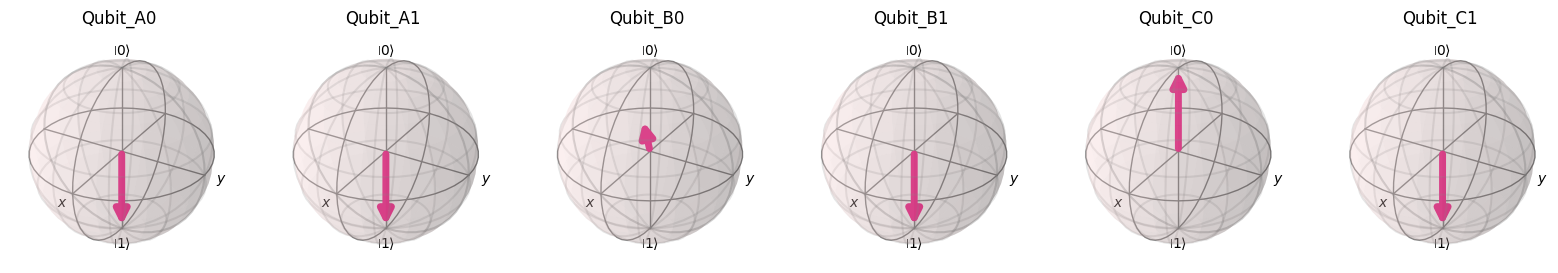

<IPython.core.display.Latex object>

In [9]:
fig = plot_bloch_multivector(statevector)

custom_labels = ['Qubit_A0', 'Qubit_A1', 'Qubit_B0', 'Qubit_B1', 'Qubit_C0', 'Qubit_C1']
# Personalizar los títulos de los ejes
for ax, label in zip(fig.axes, custom_labels):
    ax.set_title(label, pad=28)
plt.show()

display(array_to_latex(Statevector(statevector), prefix="\\ket{Salida_{statevector}} = "))

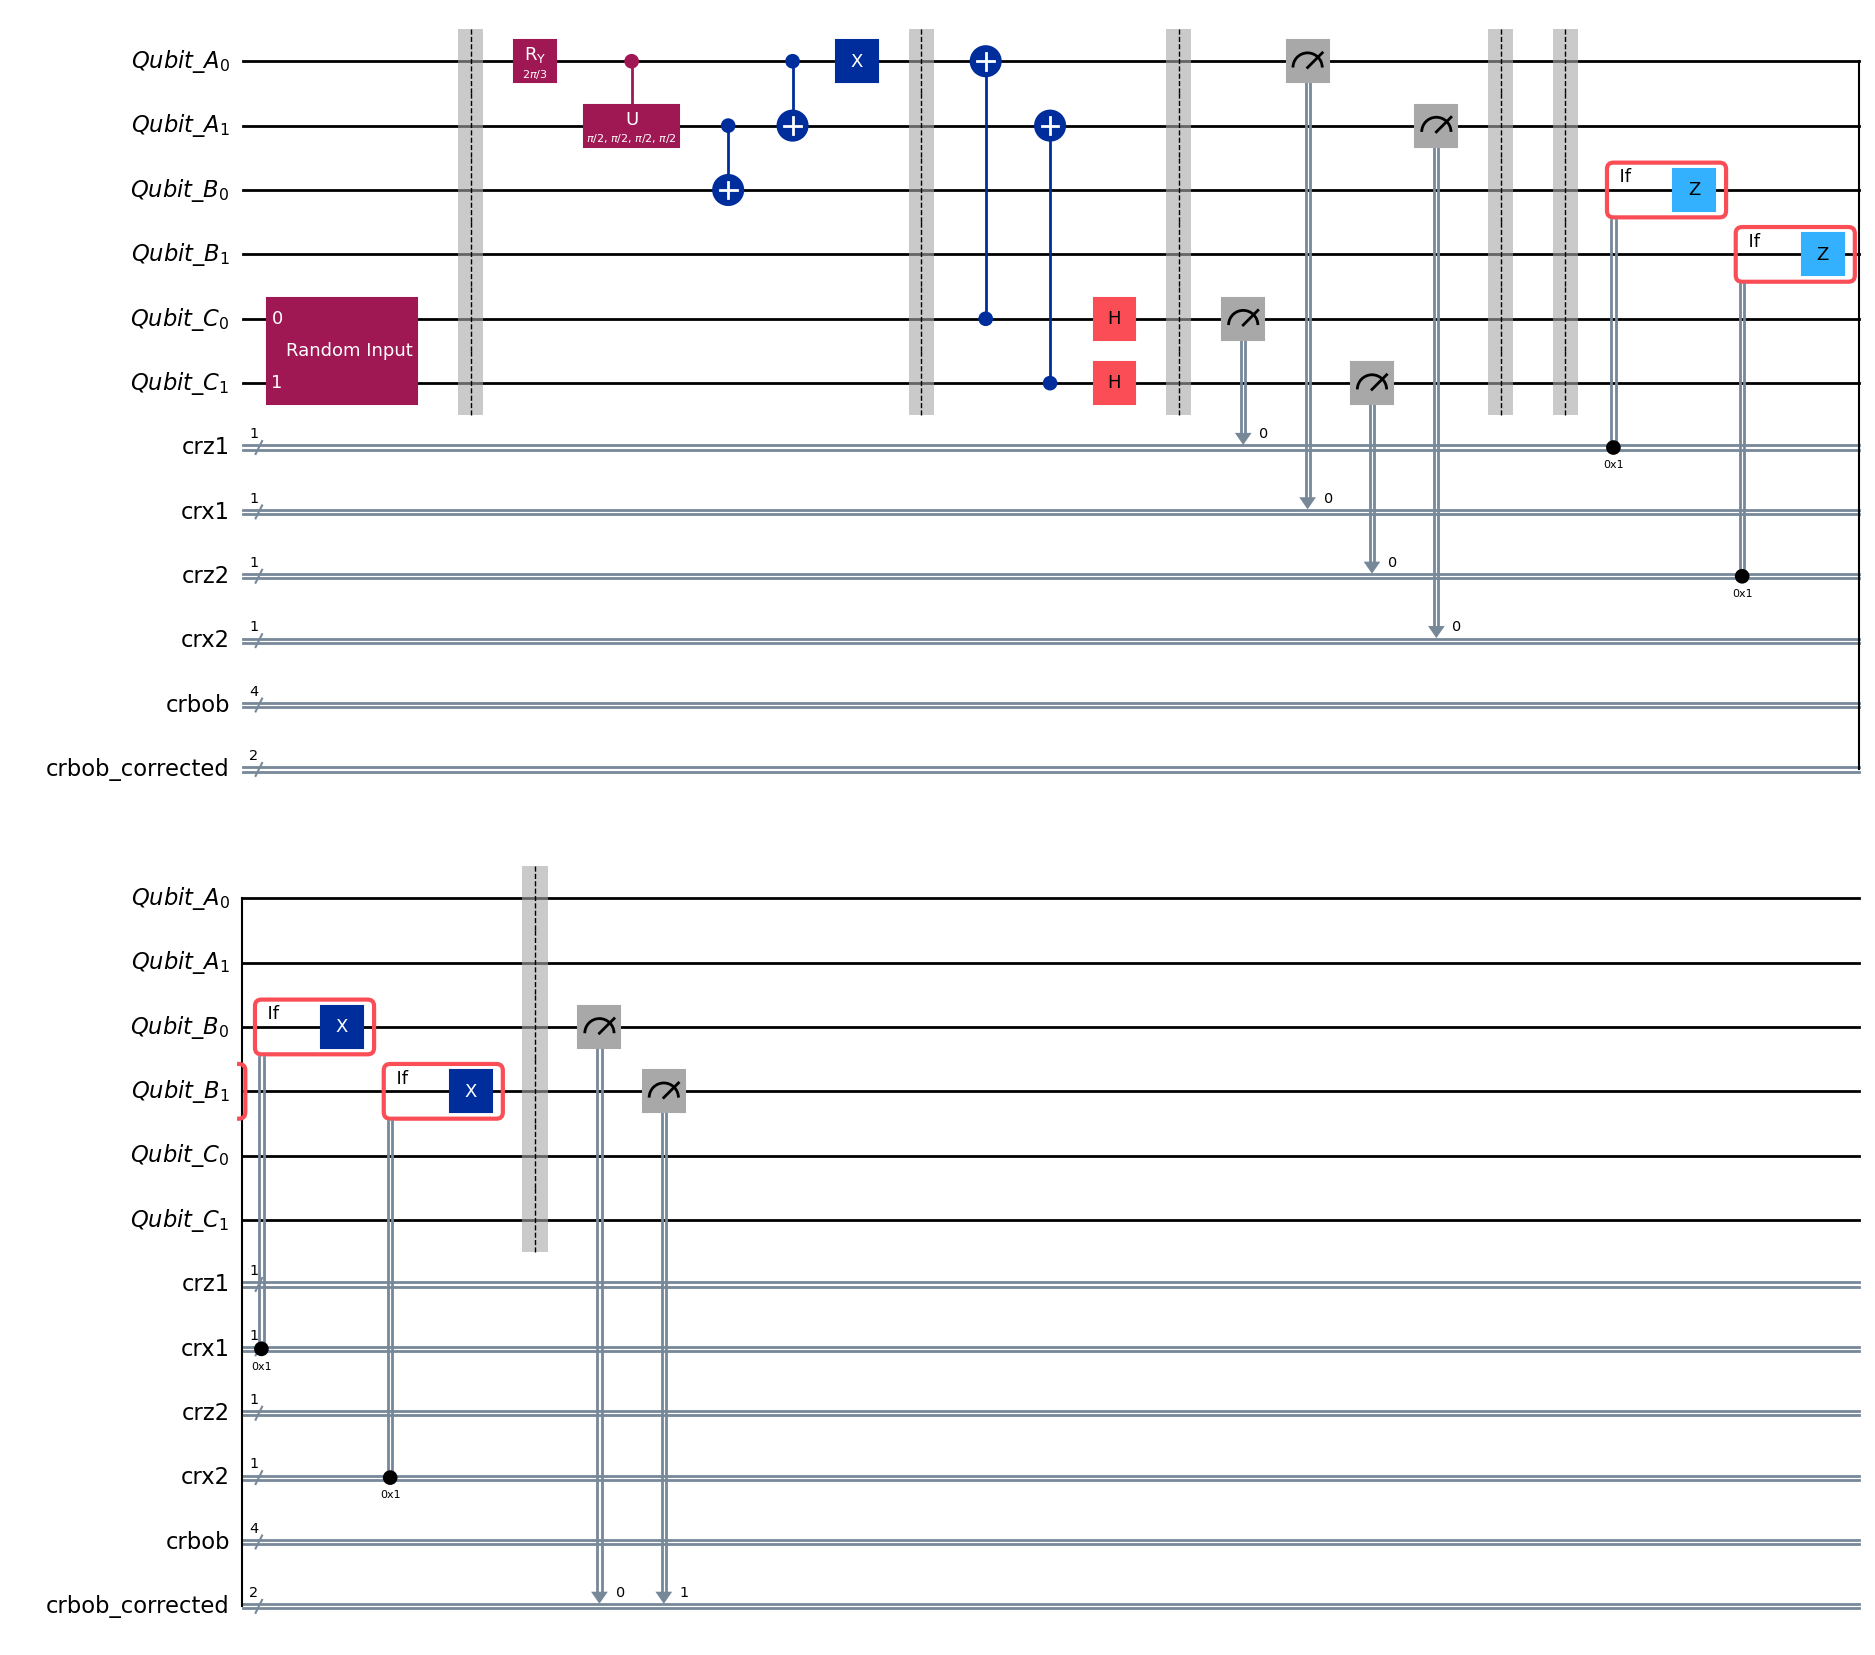

In [10]:
teleport_cir.barrier() # Uso de "barrier" (barrera) para separar las diversas etapas

# Crear un registro clásico de tamaño 2 para medir QEntanglem_B
crbob_corrected = ClassicalRegister(2, name='crbob_corrected')
teleport_cir.add_register(crbob_corrected)

# Medir QEntanglem_B en el registro clásico corregido
teleport_cir.measure(QEntanglem_B, crbob_corrected)

# Gráfica del circuito completo de Teletransportación Cuántica
teleport_cir.draw('mpl')
plt.show()

<Figure size 2400x600 with 0 Axes>

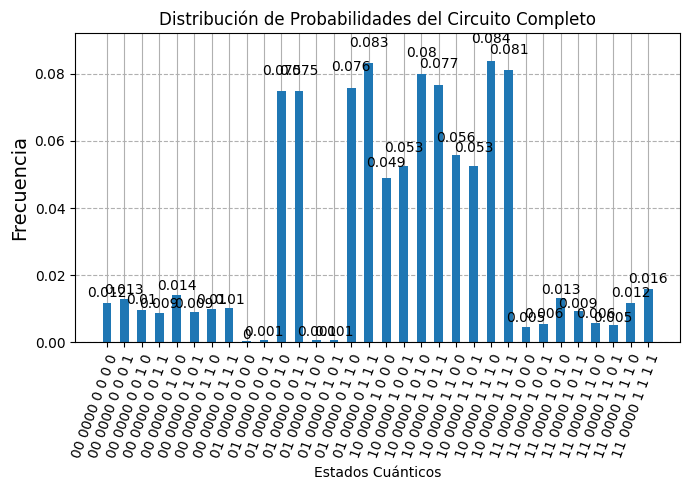

In [11]:
# Simulación del circuito completo
shots = 8192

# Ejecutar la simulación del circuito descompuesto
teleport_result = circuit_simulator.run(
    teleport_cir.decompose(reps=1), 
    shots=shots
).result()

# Obtener los resultados de las cuentas
data = teleport_result.get_counts(teleport_cir)

# Visualizar la distribución de probabilidades
#Hacer mas anchura la grafica
plt.figure(figsize=(24, 6)) 
plot_distribution(data)
plt.title("Distribución de Probabilidades del Circuito Completo")
plt.xlabel("Estados Cuánticos")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Con las siguientes instrucciones se pueden extraer de manera más clara los qubits de Alice para el estado W con 3 qubits.
alice = {}
alice['000'] = data['0 0 0'] + data['1 0 0'] + data['0 1 0'] + data['1 1 0']
alice['001'] = data['0 0 1'] + data['1 0 1'] + data['0 1 1'] + data['1 1 1']
alice['010'] = data['0 0 0'] + data['0 1 0'] + data['0 0 1'] + data['0 1 1']
alice['011'] = data['1 0 0'] + data['1 1 0'] + data['1 0 1'] + data['1 1 1']
alice['100'] = data['0 0 0'] + data['1 0 0'] + data['0 0 1'] + data['1 0 1']
alice['101'] = data['0 1 0'] + data['1 1 0'] + data['0 1 1'] + data['1 1 1']
alice['110'] = data['0 0 0'] + data['0 1 0'] + data['1 0 0'] + data['1 1 0']
alice['111'] = data['0 0 1'] + data['0 1 1'] + data['1 0 1'] + data['1 1 1']

plot_distribution(alice)
plt.show()

KeyError: '0 0 0'

In [ ]:
# Y con las siguientes instrucciones se puede extraer de manera más clara el qubit de Bob.
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']

plot_distribution(bob)
plt.show()

In [ ]:
from qiskit import __version__ as qiskit_version
from qiskit_aer import __version__ as aer_version
from platform import python_version

print('Qiskit Version:', qiskit_version)
print('Qiskit_Aer Version:', aer_version)
print('Python Version:', python_version())
print('2025 ©')